Linear Discriminative Analysis and Quadratic Discriminative Analysis for normal MNIST classification

In [139]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.special import softmax
import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse
from scipy.stats import multivariate_normal

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [6]:
rng = np.random.default_rng(123)

# 1 Load Data

In [7]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')

In [8]:
X_mnist = np.array(mnist.data) # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

# 2 Linear Discriminant Analysis

## 2.1 Algorithm

Gaussian Log Likelihood
$$\begin{align}
    P(x|\sigma_k^2,\mu_k) = -\frac{n}{2}\ln(2\pi\sigma^{2}_k) - \frac{1}{2\sigma^{2}}\sum_{i=1}^n (x - \mu_k)^2
\end{align}$$

Gaussian Density 

$$\begin{align}

\end{align}$$

Assume shared covariance $\Sigma$

$$\begin{align}
    \hat{\pi}_c &= \frac{n_c}{n}\\
    \hat{\mu}_c  &= \frac{1}{n_c}\sum_{i=1}^{n} \mathbb{1}(y^{(i)} = c) \cdot \mathbf{x}^{(i)}\\
    \hat{\Sigma} &= \frac{1}{n}\sum_{c=i}^{C}\sum_{i=1}^{n} \mathbb{1}(y^{(i)} = c)(\mathbf{x}^{(i)} - \mu_c)(\mathbf{x}^{(i)} - \mu_c)^\top
\end{align}$$

In [75]:
def LDA_fit(X, y):
    ''' 
        X : input matrix (n x d)
        y : labels 
    '''

    n,d = X.shape
    sse = np.zeros((d,d))
    classes = np.unique(y)
    K = len(classes)
    mus = np.zeros((K,d))
    pis = np.zeros(K)
    
    for idx, c in enumerate(classes):
        Xc = X[y==c]
        pis[idx] = len(Xc)/n
        mus[idx] = np.mean(Xc, axis=0)

        error = Xc - mus[idx]

        sse += error.T @ error

    return pis, mus, sse/n

In [ ]:
def predict(X, πs, μs, Σ, eps=1e-14):
    n,d = X.shape
    K = len(πs)

    # Stores likelihoods of x for each cluster 
    R = np.zeros((n,K))

    # Initialize predicted labels array
    y_preds = np.zeros(n)

    # Calculate the inverse of the covariance matrix and its determinant
    sigma_det = np.linalg.det(Σ)
    sigma_inv = np.linalg.pinv(Σ) # pinv for safety
    
    for i in range(n) :
        likelihoods = np.zeros(K)

        for k in range(K):
            # Compute the log-likelihood for each data point and each cluster
            diff = X[i] - μs[k]  # Shape (n, d)

            # Mahalanobis distance (squared) between x and mu
            exponent = np.dot(np.dot(diff, sigma_inv), diff)
            
            # Log of the Gaussian component likelihood
            log_likelihood_k = -0.5 * (d * np.log(2 * np.pi + eps) + np.log(sigma_det + eps) + exponent)
            
            # compute and store log likelihood for cluster k
            likelihoods[k] = np.log(πs[k] + eps) + log_likelihood_k

        # Find the most likely cluster for the current test data point
        pred_z = np.argmax(likelihoods)  

        y_preds[i] = pred_z
    

    return y_preds

## 2.2 Predict and Evaluate

In [77]:
pis, mus, sse = LDA_fit(X_mnist_train, Y_mnist_train)

Plot the learned cluster centers

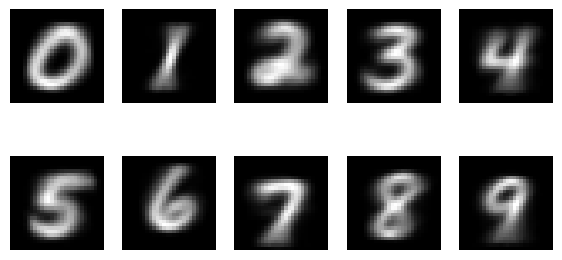

In [78]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = mus[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    # plt.title(k)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

Get cluster assignments based on likelihood

In [129]:
zs = predict(X_mnist_test, pis, mus, sse)

In [130]:
accuracy = accuracy_score(zs, Y_mnist_test)

In [131]:
print("Accuracy :", accuracy)

Accuracy : 0.823


# 3 Quadratic Discriminative Analysis

## 3.1 Algorithm

Assume each class had different covariance $\Sigma$

$$\begin{align}
    \hat{\pi}_c &= \frac{n_c}{n}\\
    \hat{\mu}_c  &= \frac{1}{n_c}\sum_{i=1}^{n} \mathbb{1}(y^{(i)} = c) \cdot \mathbf{x}^{(i)}\\
    \hat{\Sigma}_c &= \frac{1}{n_c}\sum_{i=1}^{n} \mathbb{1}(y^{(i)} = c)(\mathbf{x}^{(i)} - \mu_c)(\mathbf{x}^{(i)} - \mu_c)^\top
\end{align}$$

In [135]:
def QDA_fit(X, y):
    ''' 
        X : input matrix (n x d)
        y : labels 
    '''

    n,d = X.shape

    classes = np.unique(y)
    K = len(classes)

    sse = np.zeros((K,d,d))
    mus = np.zeros((K,d))
    pis = np.zeros(K)
    
    for idx, c in enumerate(classes):
        Xc = X[y==c]
        pis[idx] = len(Xc)/n
        mus[idx] = np.mean(Xc, axis=0)

        error = Xc - mus[idx]

        sse[idx] = (error.T @ error)/len(Xc)

    return pis, mus, sse

In [ ]:
import numpy as np

def log_multivariate_normal_pdf(X, mean, cov, eps=1e-6):
    """
    Computes the log-likelihood of each row in X under a multivariate normal distribution
    with the given mean and covariance matrix.
    
    Inputs:
    - X: (n, d) data matrix
    - mean: (d,) mean vector
    - cov: (d, d) covariance matrix
    - eps: small regularization constant to make cov positive definite
    
    Output:
    - logpdf: (n,) array of log-likelihoods
    """
    n, d = X.shape

    # Regularize covariance matrix to ensure positive definiteness
    cov_reg = cov + eps * np.eye(d)

    try:
        # Use Cholesky decomposition 
        L = np.linalg.cholesky(cov_reg)
        diff = X - mean

        # Solve triangular system: L @ y = diff.T
        sol = np.linalg.solve(L, diff.T)

        # Mahalanobis distance: sum of squares of solved vectors
        mahal = np.sum(sol**2, axis=0)

        # Log determinant from Cholesky: log|Σ| = 2 * sum(log(diag(L)))
        logdet = 2.0 * np.sum(np.log(np.diag(L)))

    except np.linalg.LinAlgError:
        # Fallback: use pseudoinverse and slogdet
        inv_cov = np.linalg.pinv(cov_reg)
        diff = X - mean
        mahal = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
        sign, logdet = np.linalg.slogdet(cov_reg)
        if sign != 1:
            raise ValueError("Covariance matrix is not positive semi-definite")

    # Log-likelihood
    return -0.5 * (d * np.log(2 * np.pi) + logdet + mahal)


In [ ]:
def QDA_predict(X, πs, μs, Σ, eps=1e-14):
    n,d = X.shape
    K = len(πs)

    # Stores likelihoods of x for each cluster 
    R = np.zeros((n,K))

    likelihoods = np.zeros((K,n))

    for k in range(K):
        # log likelihood
        ll_k = log_multivariate_normal_pdf(X, mean=μs[k], cov=Σ[k])

        # Full component weighted log-likelihood
        full_ll_k = np.log(πs[k] + eps) + ll_k
        
        likelihoods[k] = full_ll_k

    # Find the most likely cluster for the current test data point
    y_preds = np.argmax(likelihoods, axis=0)

    return y_preds

## 3.2 Predict and Evaluate

In [221]:
pis, mus, sse = QDA_fit(X_mnist_train, Y_mnist_train)

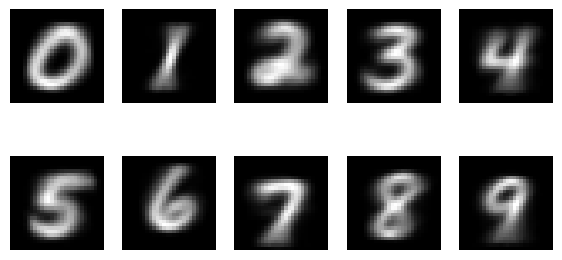

In [222]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = mus[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    # plt.title(k)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [265]:
zs = QDA_predict(X_mnist_test, pis, mus, sse)

In [266]:
accuracy = accuracy_score(zs, Y_mnist_test)

In [267]:
print("Accuracy :", accuracy)

Accuracy : 0.676
